In [2]:
import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
import dask.dataframe as dd
import datetime
import logging
import numpy as np
import pandas as pd
from dask.distributed import Client, progress
from numba import njit, types
from numba.typed import List
import time

# Configuração do logging
logging.basicConfig(level=logging.INFO)

# Configuração do cliente Dask
client = Client(n_workers=10, threads_per_worker=1, memory_limit='6.4GB')
logging.info(client)

# Caminhos dos arquivos
raw_dataset_path = '../datasets/BTCUSDT-Trades-compressed/'
output_base_path = '../output'
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
output_path = f'{output_base_path}_v{timestamp}'

INFO:root:<Client: 'tcp://127.0.0.1:52600' processes=10 threads=10, memory=59.60 GiB>


In [11]:
def read_parquet_files_optimized(raw_dataset_path, file):
    """Lê arquivos Parquet de forma otimizada."""
    parquet_pattern = os.path.join(raw_dataset_path, file)
    df_dask = dd.read_parquet(
        parquet_pattern,
        columns=['price', 'qty', 'quoteQty', 'time'],
        engine='pyarrow',
        dtype={'price': 'float32', 'qty': 'float32', 'quoteQty': 'float32'}
    )
    return df_dask

def assign_side_optimized(df):
    """Atribui o lado da negociação com base na mudança de preço."""
    df['side'] = np.where(df['price'].shift() > df['price'], 1,
                          np.where(df['price'].shift() < df['price'], -1, np.nan))
    df['side'] = df['side'].ffill().fillna(1).astype('int8')
    return df

def apply_operations_optimized(df_dask, meta):
    """Aplica operações otimizadas no DataFrame."""
    df_dask = df_dask.map_partitions(assign_side_optimized, meta=meta)
    df_dask['dollar_imbalance'] = df_dask['quoteQty'] * df_dask['side']
    return df_dask

# Função compilada com numba
@njit(
    types.Tuple((
        types.ListType(types.Tuple((
            types.float64,  # start_time
            types.float64,  # end_time
            types.float64,  # open
            types.float64,  # high
            types.float64,  # low
            types.float64,  # close
            types.float64,  # imbalance_col
            types.float64,  # total_volume_buy_usd
            types.float64,  # total_volume_usd
            types.float64   # total_volume
        ))),
        types.float64,  # exp_T
        types.float64,  # exp_dif
        types.Tuple((
            types.float64,  # bar_open
            types.float64,  # bar_high
            types.float64,  # bar_low
            types.float64,  # bar_close
            types.float64,  # bar_start_time
            types.float64,  # bar_end_time
            types.float64,  # current_imbalance
            types.float64,  # buy_volume_usd
            types.float64,  # total_volume_usd
            types.float64   # total_volume
        ))
    ))(
        types.float64[:],  # prices
        types.float64[:],  # times
        types.float64[:],  # imbalances
        types.int8[:],     # sides
        types.float64[:],  # qtys
        types.float64,     # init_T
        types.float64,     # init_dif
        types.float64,     # alpha_volume
        types.float64,     # alpha_imbalance
        types.Tuple((
            types.float64,  # bar_open
            types.float64,  # bar_high
            types.float64,  # bar_low
            types.float64,  # bar_close
            types.float64,  # bar_start_time
            types.float64,  # bar_end_time
            types.float64,  # current_imbalance
            types.float64,  # buy_volume_usd
            types.float64,  # total_volume_usd
            types.float64   # total_volume
        ))
    )
)
def process_partition_imbalance_numba(
    prices, times, imbalances, sides, qtys,
    init_T, init_dif, alpha_volume, alpha_imbalance, res_init
):
    """Processa uma partição usando numba para aceleração."""
    exp_T = init_T
    exp_dif = init_dif
    threshold = exp_T * abs(exp_dif)

    bars = List()  # Lista tipada para armazenar as barras formadas

    # Desempacota res_init
    bar_open, bar_high, bar_low, bar_close, bar_start_time, bar_end_time, \
    current_imbalance, buy_volume_usd, total_volume_usd, total_volume = res_init

    # Verifica se res_init está inicializado (usando -1.0 como sentinela para não inicializado)
    if bar_open == -1.0:
        # Reseta as variáveis de agregação
        bar_open = np.nan
        bar_high = -np.inf
        bar_low = np.inf
        bar_close = np.nan
        bar_start_time = np.nan
        bar_end_time = np.nan
        current_imbalance = 0.0
        buy_volume_usd = 0.0
        total_volume_usd = 0.0
        total_volume = 0.0

    for i in range(len(prices)):
        if np.isnan(bar_open):
            bar_open = prices[i]
            bar_start_time = times[i]

        trade_price = prices[i]
        bar_high = max(bar_high, trade_price)
        bar_low = min(bar_low, trade_price)
        bar_close = trade_price

        trade_imbalance = imbalances[i]

        if sides[i] > 0:
            buy_volume_usd += trade_imbalance

        total_volume += qtys[i]
        total_volume_usd += abs(trade_imbalance)
        current_imbalance += trade_imbalance
        imbalance = abs(current_imbalance)

        if imbalance >= threshold:
            bar_end_time = times[i]

            # Salva a barra formada
            bars.append((
                bar_start_time, bar_end_time, bar_open, bar_high, bar_low, bar_close,
                current_imbalance, buy_volume_usd, total_volume_usd, total_volume
            ))

            # Atualiza os valores exponenciais
            if exp_dif == 1.0:
                exp_T = total_volume_usd
                exp_dif = abs(2 * buy_volume_usd / total_volume_usd - 1)
            else:
                exp_T += alpha_volume * (total_volume_usd - exp_T)
                exp_dif += alpha_imbalance * (abs(2 * buy_volume_usd / total_volume_usd - 1) - exp_dif)

            threshold = exp_T * abs(exp_dif)

            # Reseta as variáveis de agregação
            bar_open = np.nan
            bar_high = -np.inf
            bar_low = np.inf
            bar_close = np.nan
            bar_start_time = np.nan
            bar_end_time = np.nan
            current_imbalance = 0.0
            buy_volume_usd = 0.0
            total_volume_usd = 0.0
            total_volume = 0.0

    # Prepara o estado final para a próxima partição
    final_state = (
        bar_open, bar_high, bar_low, bar_close,
        bar_start_time, bar_end_time, current_imbalance,
        buy_volume_usd, total_volume_usd, total_volume
    )

    return bars, exp_T, exp_dif, final_state

def create_imbalance_dollar_bars_numba(partition, init_T, init_dif, res_init, alpha_volume, alpha_imbalance):
    """Função wrapper para processar uma partição com numba."""
    # Converte a partição para arrays numpy
    prices = partition['price'].values.astype(np.float64)
    times = partition['time'].values.astype(np.float64)
    imbalances = partition['dollar_imbalance'].values.astype(np.float64)
    sides = partition['side'].values.astype(np.int8)
    qtys = partition['qty'].values.astype(np.float64)

    # Inicializa res_init se vazio ou inválido
    if res_init is None or len(res_init) != 10:
        res_init = (-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0)

    # Processa a partição usando a função compilada com numba
    bars, exp_T, exp_dif, res_init = process_partition_imbalance_numba(
        prices, times, imbalances, sides, qtys,
        init_T, init_dif, alpha_volume, alpha_imbalance, res_init
    )

    # Converte as barras para um DataFrame
    if len(bars) > 0:
        bars_df = pd.DataFrame(bars, columns=[
            'start_time', 'end_time', 'open', 'high', 'low', 'close',
            'imbalance_col', 'total_volume_buy_usd', 'total_volume_usd', 'total_volume'
        ])
    else:
        # Retorna um DataFrame vazio com as colunas apropriadas
        bars_df = pd.DataFrame(columns=[
            'start_time', 'end_time', 'open', 'high', 'low', 'close',
            'imbalance_col', 'total_volume_buy_usd', 'total_volume_usd', 'total_volume'
        ])

    return bars_df, exp_T, exp_dif, res_init

def batch_create_imbalance_dollar_bars_optimized(df_dask, init_T, init_dif, res_init, alpha_volume, alpha_imbalance):
    """Processa partições em lote para criar barras de desequilíbrio em dólares."""
    results = []
    for partition in range(df_dask.npartitions):
        logging.info(f'Processando partição {partition+1} de {df_dask.npartitions}')
        part = df_dask.get_partition(partition).compute()

        bars, init_T, init_dif, res_init = create_imbalance_dollar_bars_numba(
            part, init_T, init_dif, res_init, alpha_volume, alpha_imbalance
        )
        results.append(bars)
        # if partition == 1:
        #     df =  part[550_000:650_000]
        #     df.to_excel(f'{partition}.xlsx')
        #     # print(init_T)
        #     # print(init_dif)
        #     # print(res_init)

        #     break
    # Filtra DataFrames vazios
    results = [df for df in results if not df.empty]
    if results:
        results_df = pd.concat(results, ignore_index=True)
    else:
        # Retorna um DataFrame vazio com as colunas apropriadas se não houver resultados
        results_df = pd.DataFrame(columns=[
            'start_time', 'end_time', 'open', 'high', 'low', 'close',
            'imbalance_col', 'total_volume_buy_usd', 'total_volume_usd', 'total_volume'
        ])
    return results_df, init_T, init_dif, res_init

In [13]:
# Meta DataFrame para map_partitions
meta = pd.DataFrame({
    'price': pd.Series(dtype='float32'),
    'qty': pd.Series(dtype='float32'),
    'quoteQty': pd.Series(dtype='float32'),
    'time': pd.Series(dtype='float64'),  # Alterado para float64 para compatibilidade com Numba
    'side': pd.Series(dtype='int8')
})

# Listar arquivos
files = [f for f in os.listdir(raw_dataset_path) if os.path.isfile(os.path.join(raw_dataset_path, f))]
file_count = len(files)

results = pd.DataFrame()
init_T0 = 1_000_000
init_T = init_T0
init_dif = 1.0
alpha_volume = 0.1
alpha_imbalance = 0.9
res_init = (-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0)  # Estado inicial

# Dicionário para armazenar os tempos de processamento
processing_times = {}
# file_count
for number in range(11, file_count):
    logging.info(f"Dask n{number} de {file_count-1}")
    file = f'combined_file_{number}.parquet'

    if not os.path.exists(os.path.join(raw_dataset_path, file)):
        logging.warning(f"Arquivo {file} não encontrado. Pulando para o próximo.")
        continue

    # Inicia a medição do tempo
    start_time = time.time()

    df_dask = read_parquet_files_optimized(raw_dataset_path, file)

    df_dask = apply_operations_optimized(df_dask, meta)

    bars, init_T, init_dif, res_init = batch_create_imbalance_dollar_bars_optimized(
        df_dask, init_T, init_dif, res_init, alpha_volume, alpha_imbalance
    )
    results = pd.concat([results, bars], ignore_index=True)

    # Finaliza a medição do tempo
    end_time = time.time()
    elapsed_time = end_time - start_time
    elapsed_time_minutes = elapsed_time / 60  # Converte para minutos

    # Armazena o tempo de processamento
    processing_times[file] = elapsed_time_minutes
    logging.info(f"Tempo de processamento para {file}: {elapsed_time_minutes:.2f} minutos")

# Salvar

output_file = f'{output_path}-{alpha_volume}-{alpha_imbalance}-{init_T0}.xlsx'
results.to_excel(output_file, index=False)
logging.info(f"Resultados salvos em {output_file}")

# Exibe os tempos de processamento
logging.info("Tempos de processamento por arquivo:")
for file, time_minutes in processing_times.items():
    logging.info(f"{file}: {time_minutes:.2f} minutos")



INFO:root:Dask n11 de 11
INFO:root:Processando partição 1 de 18
INFO:root:Processando partição 2 de 18
INFO:root:Processando partição 3 de 18
INFO:root:Processando partição 4 de 18
INFO:root:Processando partição 5 de 18
INFO:root:Processando partição 6 de 18
INFO:root:Processando partição 7 de 18
INFO:root:Processando partição 8 de 18
INFO:root:Processando partição 9 de 18
INFO:root:Processando partição 10 de 18
INFO:root:Processando partição 11 de 18
INFO:root:Processando partição 12 de 18
INFO:root:Processando partição 13 de 18
INFO:root:Processando partição 14 de 18
INFO:root:Processando partição 15 de 18
INFO:root:Processando partição 16 de 18
INFO:root:Processando partição 17 de 18
INFO:root:Processando partição 18 de 18
INFO:root:Processando partição 19 de 18
INFO:root:Tempo de processamento para combined_file_11.parquet: 0.37 minutos
INFO:root:Resultados salvos em ../output_v20250116-120019-0.1-0.9-1000000.xlsx
INFO:root:Tempos de processamento por arquivo:
INFO:root:combined_fi

In [5]:
results_ = results.copy()
if not results_.empty:
    results_['start_time'] = pd.to_datetime(results_['start_time'], unit='ns')  # Ajuste para 's' se 'time' era em segundos
    results_['end_time'] = pd.to_datetime(results_['end_time'], unit='ns')
    results_['params'] = f'v{init_T0}-imb{alpha_imbalance}-vol{alpha_volume}-{timestamp}'
results_

,start_time,end_time,open,high,low,close,imbalance_col,total_volume_buy_usd,total_volume_usd,total_volume,params
0,2017-08-17 04:00:28.321999872,2017-08-18 16:55:58.616999936,4261.48,4485.39,4134.61,4251.80,1.000885e+06,4.238032e+06,7.475179e+06,1.735415e+03,v1000000-imb0.9-vol0.1-20250115-224532
1,2017-08-18 16:56:24.128000000,2017-09-14 11:52:14.388000000,4251.80,4939.19,3400.00,3509.99,1.002290e+06,4.305223e+07,8.510216e+07,1.998808e+04,v1000000-imb0.9-vol0.1-20250115-224532
2,2017-09-14 11:52:14.388000000,2017-09-15 07:52:19.246000128,3510.00,3666.00,3032.00,3032.00,3.658945e+05,2.795743e+06,5.225592e+06,1.548972e+03,v1000000-imb0.9-vol0.1-20250115-224532
3,2017-09-15 07:52:19.246000128,2017-10-02 01:14:07.431000064,3031.00,4448.00,2817.00,4448.00,-9.315520e+05,2.878924e+07,5.851003e+07,1.513701e+04,v1000000-imb0.9-vol0.1-20250115-224532
4,2017-10-02 01:14:07.431000064,2017-10-06 02:03:35.531000064,4449.00,4561.63,4110.00,4328.00,-3.909339e+05,7.067434e+06,1.452580e+07,3.391370e+03,v1000000-imb0.9-vol0.1-20250115-224532
...,...,...,...,...,...,...,...,...,...,...,...
189,2022-12-21 11:15:59.704000000,2023-03-02 13:52:54.800999936,16857.62,25250.00,16333.00,23316.00,2.138769e+09,2.026227e+11,4.031066e+11,1.864511e+07,v1000000-imb0.9-vol0.1-20250115-224532
190,2023-03-02 13:52:54.800999936,2023-05-20 09:29:47.556999936,23316.00,31000.00,19549.09,26895.16,1.053441e+09,1.468190e+11,2.925845e+11,1.159971e+07,v1000000-imb0.9-vol0.1-20250115-224532
191,2023-05-20 09:29:47.584000000,2023-06-09 16:23:13.968999936,26895.16,28447.14,25351.02,26506.70,6.965675e+08,1.058534e+10,2.047412e+10,7.627306e+05,v1000000-imb0.9-vol0.1-20250115-224532
192,2023-06-09 16:23:13.968999936,2023-12-07 10:06:10.302000128,26506.70,44488.00,24800.00,43250.21,5.087293e+09,9.899765e+10,1.929080e+11,6.299677e+06,v1000000-imb0.9-vol0.1-20250115-224532


In [12]:
import pandas as pd
from sqlalchemy import create_engine

# host = "superset-postgresql.default.svc.cluster.local"  # Nome do serviço no Kubernetes÷
host = "localhost"  # Agora o PostgreSQL está acessível via localhost
port = 5432  # Porta do PostgreSQL
dbname = "superset"  # Nome do banco de dados
user = "superset"  # Usuário do banco de dados
password = "superset"  # Senha do banco de dados


# Conectar ao banco de dados PostgreSQL usando SQLAlchemy
connection_string = f"postgresql://{user}:{password}@{host}:{port}/{dbname}"

with create_engine(connection_string).connect() as connection:
    # Enviar o DataFrame para o PostgreSQL
    results_.to_sql('imbalance-bars-start', connection, if_exists='append', index=False)

    print("Dados enviados para o banco de dados com sucesso!")


Dados enviados para o banco de dados com sucesso!


In [7]:
# import os
# import pyarrow.parquet as pq
# import pyarrow.compute as pc
# import pyarrow as pa
# from datetime import datetime

# number = 1
# file = f'combined_file_{number}.parquet'
# raw_dataset_path = '../datasets/BTCUSDT-Trades-compressed/'
# parquet_pattern = os.path.join(raw_dataset_path, file)


# tabela = pq.read_table(parquet_pattern)
# print("Arquivo Parquet lido com sucesso.")


# # Verificando o schema da tabela para entender os tipos das colunas
# print("\nSchema da Tabela Original:")
# print(tabela.schema)

# # # Definindo os limites de data como scalars de timestamp
# # data_inferior_str = '2017-08-17 09:51:31.739000082'
# # data_superior_str = '2017-08-17 22:28:02.939000130'

# # Definindo os limites de data como scalars de timestamp
# data_inferior_str = '2018-01-17 09:51:31'
# data_superior_str = '2018-01-18 22:28:03'

# # Converter strings para objetos datetime

# data_inferior_dt = datetime.strptime(data_inferior_str, "%Y-%m-%d %H:%M:%S")
# data_superior_dt = datetime.strptime(data_superior_str, "%Y-%m-%d %H:%M:%S")
# print("\nStrings convertidas para objetos datetime com sucesso.")


# data_inferior = pa.scalar(data_inferior_dt, type=pa.timestamp('ns'))
# data_superior = pa.scalar(data_superior_dt, type=pa.timestamp('ns'))
# print("Scalars de timestamp criados com sucesso.")


# # Verifique se a coluna 'time' está no tipo de dado timestamp
# time_field = tabela.schema.field('time')

# # Aplicando o filtro na coluna 'time' usando pc.and_ em vez de &

# filtro = pc.and_(
#     pc.greater_equal(tabela['time'], data_inferior),
#     pc.less_equal(tabela['time'], data_superior)
# )


# # Filtrando a tabela

# # condicao1 = pc.greater_equal(tabela['time'], data_inferior)

# # condicao2 = pc.less_equal(tabela['time'], data_superior)

# tabela_filtrada = tabela.filter(filtro)
# # print(f"Número de linhas após filtragem: {tabela_filtrada.num_rows}")


# # Inspecionar os primeiros registros da tabela filtrada
# # Filtrando a tabela

# # tabela_filtrada = tabela.filter(condicao1)
# # tabela_filtrada = tabela_filtrada.filter(condicao2)

# df_filtrada = tabela_filtrada.to_pandas()
# print("\nPrimeiros registros da Tabela Filtrada (DataFrame Pandas):")
# # print(df_filtrada.tail())

# # Realizar agregações

# min_price = pc.min(tabela_filtrada['price']).as_py()
# max_price = pc.max(tabela_filtrada['price']).as_py()
# first_price = pc.first(tabela_filtrada['price']).as_py()
# last_price = pc.last(tabela_filtrada['price']).as_py()
# sum_quoteQty = pc.sum(tabela_filtrada['quoteQty']).as_py()
# count_quoteQty = pc.count(tabela_filtrada['quoteQty']).as_py()
# mean_price = pc.mean(tabela_filtrada['price']).as_py()

# print("\nAgregações realizadas com sucesso.")


# # Coletar os resultados em um dicionário
# aggregates = {
#     'price_min': min_price,
#     'price_max': max_price,
#     'price_first': first_price,
#     'price_last': last_price,
#     'quoteQty_sum': sum_quoteQty,
#     'quoteQty_count': count_quoteQty,
#     'price_mean': mean_price
# }

# # Exibir os resultados
# print("\nResultados das Agregações:")
# for chave, valor in aggregates.items():
#     print(f"{chave}: {valor}")


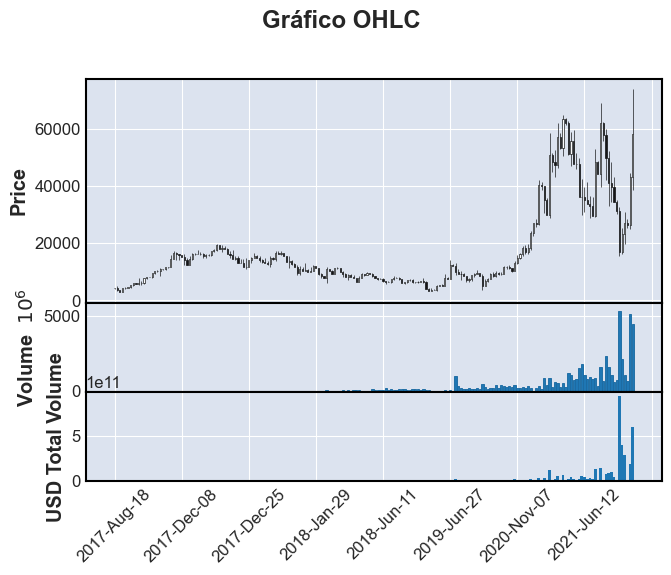

In [8]:
import mplfinance as mpf
# import matplotlib
import pandas as pd
# matplotlib.use('TkAgg')  # Ou outro backend interativo

df = results_.copy()

# Convertendo a coluna 'start_time' para o índice do DataFrame
df['end_time'] = pd.to_datetime(df['end_time'])
df.set_index('end_time', inplace=True)

# Selecionando apenas as colunas necessárias para o mplfinance
df = df[['open', 'high', 'low', 'close', 'imbalance_col', 'total_volume_usd']]

# Renomeando as colunas para um formato mais amigável
df.rename(columns={
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'imbalance_col': 'Volume'}, inplace=True)

ap = mpf.make_addplot(df['total_volume_usd'], panel=2, color='C0', ylabel='USD Total Volume', type='bar', width=1)
# Plotando o gráfico OHLC em preto e branco
fig = mpf.plot(df, type='candle', title='Gráfico OHLC', volume=True, addplot=ap, show_nontrading=False)

# Show the plot
mpf.show()
